- Start with general stuff

In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib qt

import numpy as np
import matplotlib.pyplot as plt
import h5py, os
from tqdm import tqdm

import corporate_design_colors_v3 as cpd

no style found


In [4]:
def bin_y_over_x(x, y, x_bins):
    
    # Apply binning based on histogram function
    x_nu = np.append(x_bins, 2*x_bins[-1]-x_bins[-2])
    x_nu = x_nu - (x_nu[1] - x_nu[0])/2
        # Instead of N_x, gives fixed axis.
        # Solves issues with wider ranges, than covered by data
    _count, _ = np.histogram(x,
                             bins = x_nu,
                             weights=None)
    _count = np.array(_count, dtype='float64')
    _count[_count==0] = np.nan

    _sum, _ = np.histogram(x,
                           bins = x_nu,
                           weights = y)    
    return _sum/_count

- Get the gap

In [5]:
path = os.getcwd()
file = h5py.File(f'{path}\..\\23 11 15 PR22e9 0.025G0\\23_11_15_S22_tunneljuntion_0.025G0_1.hdf5', 'r')
list(file['measurement'].keys())

['single IV_+0.00mT_nanGHz_+nandBm']

In [6]:
V1_AMP = 1000
V2_AMP = 10000
R_REF = 53000

mkey = "single IV_+0.00mT_nanGHz_+nandBm"

offset= file['measurement'][mkey]["offset"]["adwin"]

off_v1 = np.nanmean(offset["V1"])
off_v2 = np.nanmean(offset["V2"])
sweep = file['measurement'][mkey]["sweep"]["adwin"]

trigger = np.array(sweep['trigger'], dtype='int')
v1 = np.array(sweep['V1'], dtype='float64')
v2 = np.array(sweep['V2'], dtype='float64')

v_raw = (v1 - off_v1) / V1_AMP
i_raw = (v2 - off_v2) / V2_AMP / R_REF

v_raw_up = v_raw[trigger==1]
v_raw_down = v_raw[trigger==2]

i_raw_up = i_raw[trigger==1]
i_raw_down = i_raw[trigger==2]

V_raw = np.linspace(-6*191e-6, 6*191e-6, 360+1)

I_raw_up = bin_y_over_x(v_raw_up, i_raw_up, V_raw)
I_raw_down = bin_y_over_x(v_raw_down, i_raw_down, V_raw)

dIdV_raw_up= np.gradient(I_raw_up, V_raw)
dIdV_raw_down= np.gradient(I_raw_down, V_raw)

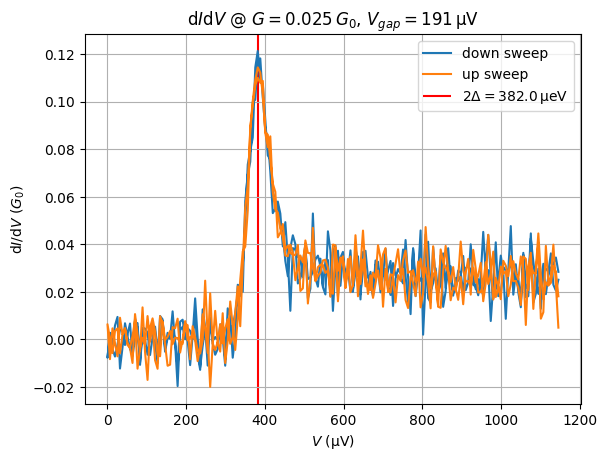

In [325]:
%matplotlib inline
plt.close(3)
plt.figure(3)

Vgap = 191e-6
G_0 = 7.7481e-5

plt.plot(np.abs(V_raw)*1e6, dIdV_raw_down/G_0, label='down sweep')
plt.plot(np.abs(V_raw)*1e6, dIdV_raw_up/G_0, label='up sweep')
ylim = plt.ylim()

# plt.vlines(Vgap*1e6, ymin=ylim[0], ymax=ylim[1], color='k', label=fr'$1\,\Delta/e = {Vgap*1e6:.1f}\,$µV', zorder=1)
plt.vlines(2*Vgap*1e6, ymin=ylim[0], ymax=ylim[1], color='red', label=fr'$2\Delta = {2*Vgap*1e6:.1f}\,$µeV', zorder=1)


plt.ylim(ylim)
plt.grid()
plt.legend()
plt.xlabel(r'$V\ ($µV$)$')
plt.ylabel(r'd$I/$d$V\ (G_0)$')
plt.title('d$I$d$V$ @ $G=0.025\,G_0$, $V_{gap}=191\,$µV')
plt.savefig('dIdV G=0.025G0 tunnelbarrier.pdf')
plt.savefig('dIdV G=0.025G0 tunnelbarrier.png')

- define constants

In [8]:
h = 6.62607015e-34  # V * A * s²
e = 1.602176634e-19 #     A * s
Vgap = 191e-6       # V
Delta = Vgap*e      # V * A * s
G_0 = 2*e**2/h      # A / V
R_0 = h/(2*e**2)    # V / A

- get theoretical IV curves from Carlos

In [163]:
path = 'CarlosIV'
arr = os.listdir(f'{path}')
arr.remove('iv.in')
arr.remove('iv.for')

v_norm = np.linspace(0,5.99,600)
V_norm = np.concatenate((-np.flip(v_norm)[:-1],v_norm))
T_theo = np.zeros(len(arr)+1, dtype='float64')
I_norm_theo = np.zeros((len(T_theo), len(v_norm)), dtype='float64')

for i in range(len(arr)):
    temp = arr[i][:-4]
    value = int(temp)*10**(-len(temp)+1)
    T_theo[i+1] = value

for i, a in enumerate(arr):
    v_norm_theo = np.genfromtxt(f'{path}/{a}')[:,0]
    i_norm_theo = np.genfromtxt(f'{path}/{a}')[:,1]
    I_norm_theo[i+1,:] = bin_y_over_x(v_norm_theo, i_norm_theo, v_norm)

I_theo = np.concatenate((-np.flip(I_norm_theo, axis=1)[:,:-1],I_norm_theo), axis=1)

dIdV_norm_theo = np.gradient(I_norm_theo, v_norm, axis=1)
dIdV_theo = np.gradient(I_theo, V_norm, axis=1)

Text(0, 0.5, 'd$I/$d$V\\ (G_0)$')

<Figure size 640x480 with 0 Axes>

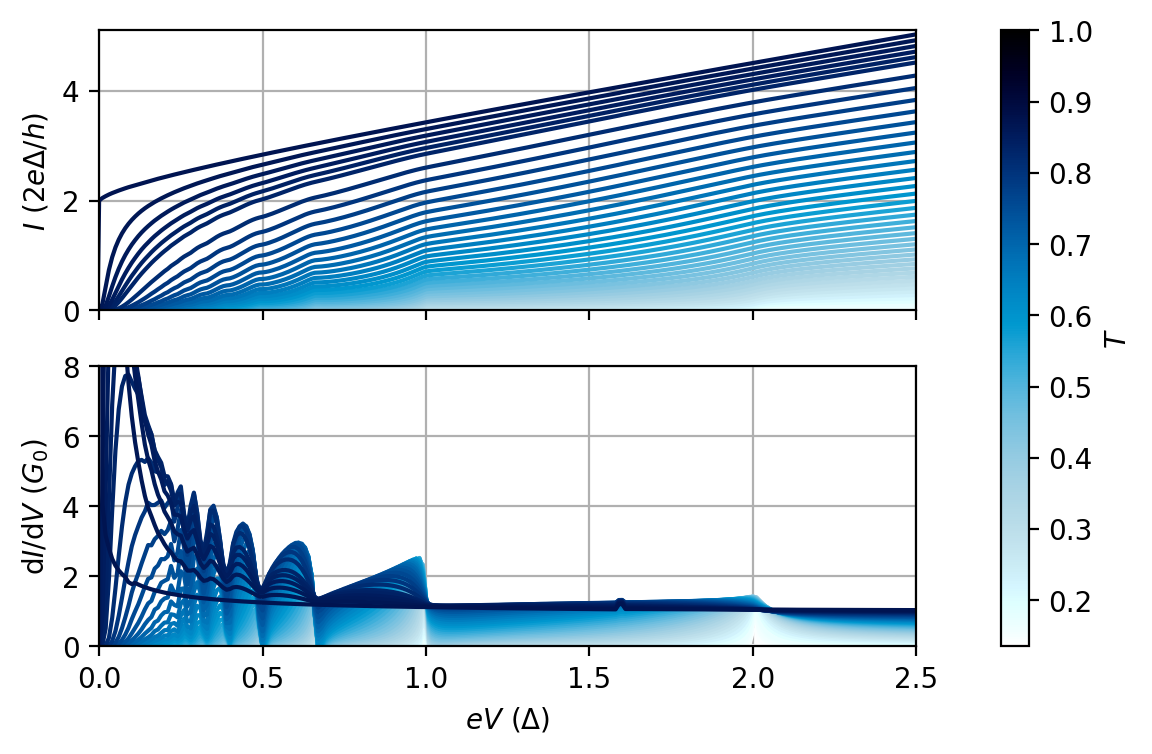

In [164]:
%matplotlib inline
plt.figure(1)
fig, axs = plt.subplots(figsize=(6,4), ncols=2, nrows=2, dpi=200,
        gridspec_kw={"width_ratios":[5.8,.2]})
gs = axs[0,1].get_gridspec()
ax11 = axs[0,0]
ax12 = axs[1,0]

t, _ = np.meshgrid(T_theo, np.ones((47,)))
im = axs[0,1].imshow(t, cmap = cpd.images(inverse=True), clim=(1, .15))
axs[0,1].remove()
axs[1,1].remove()
ax_clb = fig.add_subplot(gs[:,-1])

for i, T in enumerate(T_theo):
    ax11.plot(V_norm, I_theo[i,:], '-',label=f'{T:0.03}', color = cpd.images()((1-T*.85)))
    ax12.plot(V_norm, dIdV_theo[i,:], '-',label=f'{T:0.03}', color = cpd.images()((1-T*.85)))

cbar=fig.colorbar(im, label=r'$T$', cax=ax_clb)

ax11.set_xticklabels([])
ax11.grid()
ax12.grid()
ax11.set_xlim(0,2.5)
ax12.set_xlim(0,2.5)
ax11.set_ylim(0,5.1)
ax12.set_ylim(0,8)

ax11.set_ylabel(r'$I\ (2e\Delta/h)$')
ax12.set_xlabel(r'$eV\ (\Delta)$')
ax12.set_ylabel(r'd$I/$d$V\ (G_0)$')


- Get experimental data

In [165]:
path = os.getcwd()
file_1G0 = h5py.File(f'{path}/../23 11 10 PR22e9 1.2G0/23_11_10_1.2G_0.hdf5', 'r')
file_3G0 = h5py.File(f'{path}/../23 11 17 PR22e9 3.6G (Keysight VNA)/23_11_17_PR22e9_KeysightVNA_3.6G_0.hdf5', 'r')
file_4G0 = h5py.File(f'{path}/../23 11 15 PR22e9 4.3G/23_11_15_PR22e9_4.3G_1.hdf5', 'r')
# list(file['measurement'].keys())

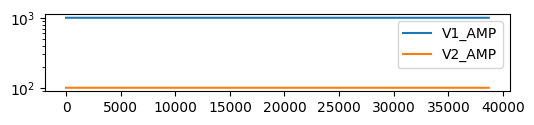

In [166]:
%matplotlib inline
plt.figure(figsize=(6,1))
plt.semilogy(file_4G0["status"]["femtos"]["amp_A"], label='V1_AMP')
plt.semilogy(file_4G0["status"]["femtos"]["amp_B"], label='V2_AMP')
plt.legend()

V1_AMP = 1000
V2_AMP_1G0 = 1000
V2_AMP_3G0 = 100
V2_AMP_4G0 = 100
R_REF = 53000

In [167]:
from torch.nn import Upsample
from torch import from_numpy

def bin_y_over_x(x, y, x_bins, upsampling=None):
    if upsampling is not None:
        k = np.full((2, len(x)), np.nan)
        k[0,:] = x
        k[1,:] = y
        m = Upsample(mode='linear', scale_factor=100)
        big = m(from_numpy(np.array([k])))
        x = np.array(big[0,0,:])
        y = np.array(big[0,1,:])
    else:
        pass

    # Apply binning based on histogram function
    x_nu = np.append(x_bins, 2*x_bins[-1]-x_bins[-2])
    x_nu = x_nu - (x_nu[1] - x_nu[0])/2
        # Instead of N_x, gives fixed axis.
        # Solves issues with wider ranges, than covered by data
    _count, _ = np.histogram(x,
                             bins = x_nu,
                             weights=None)
    _count = np.array(_count, dtype='float64')
    _count[_count==0] = np.nan

    _sum, _ = np.histogram(x,
                           bins = x_nu,
                           weights = y)    
    return _sum/_count

In [168]:
mkey = "magnetic fields_nanGHz_+nandBm"
to_pop = "no_field"

G_exp = np.array([1.3, 2.9, 3.15])
V2_AMP = np.array([V2_AMP_1G0, V2_AMP_3G0, V2_AMP_4G0])
v_shift = np.array([-0.02, -.045, -.0355])

I_up = np.full((len(G),len(V_norm)), np.nan)
I_down = np.full((len(G),len(V_norm)), np.nan)
for j, file in enumerate([file_1G0, file_3G0, file_4G0]):
    offset= file['measurement'][mkey][to_pop]["offset"]["adwin"]
    off_v1 = np.nanmean(offset["V1"])
    off_v2 = np.nanmean(offset["V2"])

    sweep = file['measurement'][mkey][to_pop]["sweep"]["adwin"]
    trigger = np.array(sweep['trigger'], dtype='int')
    v1 = np.array(sweep['V1'], dtype='float64')
    v2 = np.array(sweep['V2'], dtype='float64')

    v = v1 / V1_AMP / Vgap - v_shift[j]
    i = v2 / V2_AMP[j] / R_REF / ( 2 * e * Delta / h)

    v_up   = v[trigger==1]
    v_down = v[trigger==2]
    i_up   = i[trigger==1]
    i_down = i[trigger==2]

    I_up[j,:]   = bin_y_over_x(v_up,   i_up,   V_norm, upsampling=100)
    I_down[j,:] = bin_y_over_x(v_down, i_down, V_norm, upsampling=100)

I_exp = np.nanmean((I_up, I_down), axis=0)
dIdV_exp = np.gradient(I_exp, V_norm, axis=1)

C:\Users\oliver\AppData\Local\Temp\ipykernel_14104\1866081979.py:31: RuntimeWarning: Mean of empty slice
  I_exp = np.nanmean((I_up, I_down), axis=0)


In [223]:
weight = np.exp(-(V_norm/2)**2)

T_len = len(T_theo)

MSD = []
indices = []
for i in range(T_len):
    for j in range(T_len-i):
        j = j+i
        for k in range(T_len-j):
            k=k+j
            I_theo_temp = I_theo[i,:] + I_theo[j,:] + I_theo[k,:]
            MSD.append(np.nanmean(weight*(I_exp[0,:]-I_theo_temp)**2))
            indices.append([i,j,k])

MSD = np.array(MSD)
indices = np.array(indices)

T_exp = T_theo[indices[np.argmin(MSD),:]]


In [222]:
T_exp

array([0.25, 0.25, 0.7 ])

In [322]:
%matplotlib qt

MSD_norm = MSD[:]-np.nanmin(MSD)
MSD_norm = MSD_norm/np.max(MSD_norm)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot([T_exp[0],T_exp[0]],[0,1],'-', zs=[T_exp[2],T_exp[2]], color=cpd.curves(color='magenta')(1), zorder=0)
ax.plot([0,1],[T_exp[1],T_exp[1]],'-', zs=[T_exp[2],T_exp[2]], color=cpd.curves(color='magenta')(1), zorder=0)
ax.plot([T_exp[0],T_exp[0]],[T_exp[1],T_exp[1]],'-', zs=[0,1], color=cpd.curves(color='magenta')(1), zorder=0)
ax.scatter(
    T_theo[indices[:,0]], 
    T_theo[indices[:,1]], 
    T_theo[indices[:,2]],
    marker='.', 
    alpha=.15,
    s=10*(1-MSD_norm)**8, 
    color=cpd.images(inverse=True)((1-MSD_norm)**8),
    )

a=.3
ax.scatter(T_exp[0], T_exp[1], T_exp[2], marker='.', s=100, color=cpd.curves(color='magenta')(1), zorder=1000, label=rf't={T_exp}')
ax.plot([0,1],[0,0],'-', zs=[T_exp[2],T_exp[2]], color=cpd.curves(color='magenta')(1), zorder=1000, alpha=a)
ax.plot([0,0],[0,1],'-', zs=[T_exp[2],T_exp[2]], color=cpd.curves(color='magenta')(1), zorder=1000, alpha=a)
ax.plot([T_exp[0],T_exp[0]],[0,1],'-', zs=[1,1], color=cpd.curves(color='magenta')(1), zorder=1000, alpha=a)
ax.plot([T_exp[0],T_exp[0]],[0,0],'-', zs=[0,1], color=cpd.curves(color='magenta')(1), zorder=1000, alpha=a)
ax.plot([0,0],[0,1],'-', zs=[T_exp[2],T_exp[2]], color=cpd.curves(color='magenta')(1), zorder=1000, alpha=a)
ax.plot([0,1],[T_exp[0],T_exp[1]],'-', zs=[1,1], color=cpd.curves(color='magenta')(1), zorder=1000, alpha=a)
ax.plot([0,0],[T_exp[0],T_exp[1]],'-', zs=[0,1], color=cpd.curves(color='magenta')(1), zorder=1000, alpha=a)

ax.invert_zaxis()
ax.invert_yaxis()
ax.set_xlim3d(0,1)
ax.set_ylim3d(1,0)
ax.set_zlim3d(1,0)

ax.set_xlabel('$t_1$')
ax.set_ylabel('$t_2$')
ax.set_zlabel('$t_3$')

ax.legend()

In [181]:

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i, m in enumerate(MSD):
    ax.scatter(indices[i,0], indices[i,1], indices[i,2], marker=m)

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x00000271A2893E20> (for post_execute):


AttributeError: 'PathCollection' object has no attribute 'do_3d_projection'

AttributeError: 'PathCollection' object has no attribute 'do_3d_projection'

<Figure size 640x480 with 1 Axes>

In [ ]:

def fake_fit(Transmission, I_theo, I_exp):    
    T_len = len(Transmission)
    MSD = []
    indices = []
    for i in range(T_len):
        for j in range(T_len-i):
            j = j+i
            for k in range(T_len-j):
                k=k+j
                I_theo_temp = I_theo[i,:] + I_theo[j,:] + I_theo[k,:]
                MSD.append(np.mean((I_exp-I_theo_temp)**2))
                indices.append([i,j,k])
    MSD = np.array(MSD, dtype='float64')
    indices = np.array(indices, dtype='int8')

    argmin = np.argmin(MSD)

    transmissions = Transmission[indices[argmin]]
    I_fitted = I_theo[indices[argmin][0],:] + I_theo[indices[argmin][1],:] + I_theo[indices[argmin][2],:]

    return MSD, indices, transmissions, I_fitted

In [ ]:
# # ARCHIEVE
    
# dIdV_up   = np.gradient(I_up,   v_norm, axis=1)
# dIdV_down = np.gradient(I_down, v_norm, axis=1)

# I_up_abs   = np.nanmean((-np.flip(I_up,   axis=1), I_up),   axis=0)[:, len(V_norm)-1:]
# I_down_abs = np.nanmean((-np.flip(I_down, axis=1), I_down), axis=0)[:, len(V_norm)-1:]
# I_abs = np.nanmean((I_up_abs, I_down_abs), axis=0)

# I_smooth = np.full(np.shape(I_abs), np.nan)

# from statsmodels.api import nonparametric
# lowess = nonparametric.lowess
# for i in range(3):
#     I_smooth[i,:] = lowess(V, I, frac=frac, return_sorted=True)

# dIdV_up_abs   = np.gradient(I_up_abs,   V_norm, axis=1)
# dIdV_down_abs = np.gradient(I_down_abs, V_norm, axis=1)
# dIdV_abs = np.gradient(I_abs, V_norm, axis=1)

In [145]:
%matplotlib qt
color = ['red', 'green', 'blue']
for i in range(3):
    plt.plot(V_norm, I_exp[i,:],'.', label=i, color=color[i])
plt.grid()
plt.legend()

In [89]:
%matplotlib qt
color = ['red', 'green', 'blue']
for i in range(3):
    # plt.plot(v_norm, dIdV_up[i], '.', label=f'{i}', zorder=1, color=color[i])
    plt.plot(v_norm, I_up[i], '.', label=f'{i}', zorder=1, color=color[i])
    plt.plot(v_norm, I_down[i], '+', label=f'{i}', zorder=1, color=color[i])
    # plt.plot(V_norm, dIdV_up_abs[i], '-', label=f'{i}', color=color[i])
    # plt.plot(V_norm, dIdV_down_abs[i], '--', label=f'{i}', color=color[i])
    plt.plot(V_norm, I_abs[i], '-', label=f'{i}', color=color[i])
# plt.ylim(0,5)
plt.legend()




In [16]:
I_up[0,:] = bin_y_over_x(v_up,   i_up,   v_norm)

Text(0, 0.5, '$I (2e\\Delta/h$)')

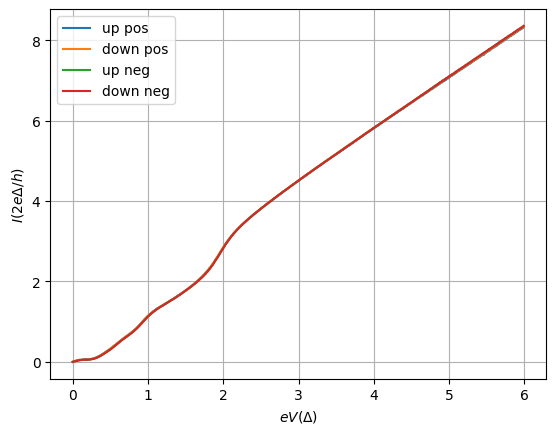

In [204]:
plt.close(4)
plt.figure(4)
plt.plot(V_norm, I_norm_up_pos,   label='up pos')
plt.plot(V_norm, I_norm_down_pos, label='down pos')
plt.plot(V_norm, I_norm_up_neg,   label='up neg')
plt.plot(V_norm, I_norm_down_neg, label='down neg')
plt.grid()
plt.legend()
plt.xlabel(r'$eV (\Delta$)')
plt.ylabel(r'$I (2e\Delta/h$)')

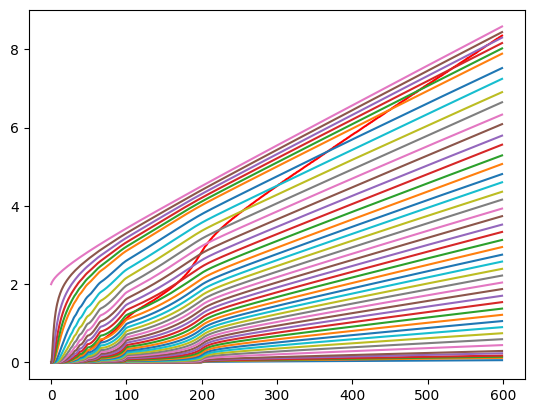

In [205]:
plt.plot(I_norm_down_neg,'r')
for i, t in enumerate(Transmission):
    plt.plot(I_norm_theo[i,:])

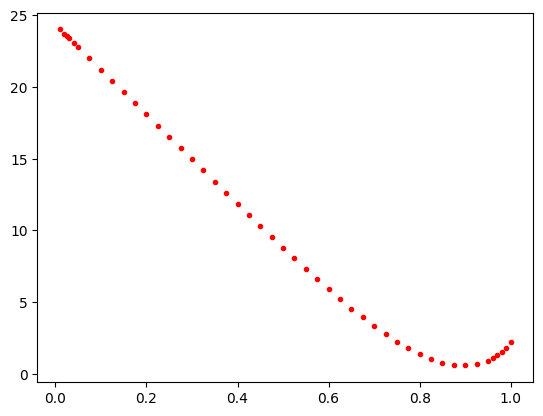

In [206]:
for i, t in enumerate(Transmission):
    plt.plot(t,np.mean((I_norm_up_pos-I_norm_theo[i,:])**2),'r.')

In [273]:
def get_theo_curves():
    arr = os.listdir('CarlosIV')
    arr.remove('iv.in')
    arr.remove('iv.for')

    Transmission = np.zeros(len(arr), dtype='float64')
    V_theo = np.linspace(0, 5.99, 600)
    I_theo = np.zeros((len(Transmission), len(V_theo)), dtype='float64')

    for i in range(len(arr)):
        temp = arr[i][:-4]
        value = int(temp)*10**(-len(temp)+1)
        Transmission[i] = value

    for i, a in enumerate(arr):
        v_theo = np.genfromtxt(f'CarlosIV/{a}')[:,0]
        i_theo = np.genfromtxt(f'CarlosIV/{a}')[:,1]
        I_theo[i,:] = bin_y_over_x(v_theo, i_theo, V_theo)
    dI_dV_theo = np.gradient(I_norm_theo, V_theo, axis=1)
    return V_theo, I_theo, dI_dV_theo, Transmission


def plot_theo_curves(V_theo, I_theo, dI_dV_theo, Transmission):
    plt.figure(1, figsize=(6,3))
    for i, T in enumerate(Transmission):
        plt.plot(V_theo, I_theo[i,:], '.',label=f'{T:0.03}')
    plt.grid()
    plt.xlim(0,2.5)
    plt.ylim(0,5.1)
    plt.xlabel(r'$V\ (\Delta/e)$')
    plt.ylabel(r'$I\ (2e\Delta/h)$')

    plt.figure(2, figsize=(6,3))
    for i, T in enumerate(Transmission):
        plt.plot(V_theo, dI_dV_theo[i,:], '.',label=f'{T:0.03}')
    plt.grid()
    plt.xlim(0,2.5)
    plt.ylim(0,8)
    plt.xlabel(r'$V\ (\Delta/e)$')
    plt.ylabel(r'd$I/$d$V\ (G_0)$')


def fake_fit(Transmission, I_theo, I_exp):    
    T_len = len(Transmission)
    MSD = []
    indices = []
    for i in range(T_len):
        for j in range(T_len-i):
            j = j+i
            for k in range(T_len-j):
                k=k+j
                I_theo_temp = I_theo[i,:] + I_theo[j,:] + I_theo[k,:]
                MSD.append(np.mean((I_exp-I_theo_temp)**2))
                indices.append([i,j,k])
    MSD = np.array(MSD, dtype='float64')
    indices = np.array(indices, dtype='int8')

    argmin = np.argmin(MSD)

    transmissions = Transmission[indices[argmin]]
    I_fitted = I_theo[indices[argmin][0],:] + I_theo[indices[argmin][1],:] + I_theo[indices[argmin][2],:]

    return MSD, indices, transmissions, I_fitted

%matplotlib qt

V_theo, I_theo, dI_dV_theo, Transmission = get_theo_curves()
# plot_theo_curves(V_theo, I_theo, dI_dV_theo, Transmission)
MSD, indices, transmissions, I_fitted = fake_fit(Transmission=Transmission, I_theo=I_norm_theo, I_exp=I_norm_up_pos)
plt.plot(np.gradient(I_norm_up_pos))
plt.plot(np.gradient(I_fitted))

In [223]:
T_len = len(Transmission)
MSD = np.zeros((T_len, T_len, T_len))

I_norms = [I_norm_up_pos, I_norm_up_neg, I_norm_down_pos, I_norm_down_neg]
MSDs = []
INDICES = []
TRANSMISSIONS = []
I_THEOS = []

for I_norm in I_norms:
    MSD = np.zeros((T_len, T_len, T_len))
    for i in range(T_len):
        for j in range(T_len):
            for k in range(T_len):
                I_theo = I_norm_theo[i,:] + I_norm_theo[j,:] + I_norm_theo[k,:]
                MSD[i,j,k] = np.mean((I_norm-I_theo)**2)

    indices = np.array(np.unravel_index(np.argmin(MSD), (T_len, T_len, T_len)))
    transmissions = Transmission[indices]
    I_theo = I_norm_theo[indices[0],:] + I_norm_theo[indices[1],:] + I_norm_theo[indices[2],:]
            
    MSDs.append(MSD)
    INDICES.append(indices)
    TRANSMISSIONS.append(transmissions)
    I_THEOS.append(I_theo)

# indices = np.array(np.unravel_index(np.argmin(MSD), (T_len, T_len, T_len)))
# transmissions = Transmission[indices]
# I_theo = I_norm_theo[indices[0],:] + I_norm_theo[indices[1],:] + I_norm_theo[indices[2],:]
TRANSMISSIONS

[array([0.175, 0.375, 0.675]),
 array([0.25 , 0.275, 0.7  ]),
 array([0.25 , 0.7  , 0.275]),
 array([0.01, 0.01, 0.01])]

In [224]:
%matplotlib qt
I_exps = [I_norm_up_pos, I_norm_up_neg, I_norm_down_pos, I_norm_down_neg]
for I in I_exps:
    plt.plot(I)

for i in range(4):
    plt.plot(I_THEOS[i])

In [48]:
T_len = len(Transmission)
MSD = np.zeros((T_len, T_len, T_len))

z=0
for i in range(T_len):
    for j in range(T_len):
        for k in range(T_len):
            I_theo = I_norm_theo[i,:] + I_norm_theo[j,:] + I_norm_theo[k,:]
            MSD[i,j,k] = np.mean((I_norm_down-I_theo)**2)
            
indices = np.array(np.unravel_index(np.argmin(MSD), (T_len, T_len, T_len)))
transmissions = Transmission[indices]
I_theo = I_norm_theo[indices[0],:] + I_norm_theo[indices[1],:] + I_norm_theo[indices[2],:]

In [232]:
T_len = len(Transmission)
MSD = np.zeros((T_len, T_len, T_len))

dIdV_exp = dIdV_norm_down_neg

for i in range(T_len):
    for j in range(T_len):
        for k in range(T_len):
            dIdV_theo = dIdV_norm_theo[i,:] + dIdV_norm_theo[j,:] + dIdV_norm_theo[k,:]
            MSD[i,j,k] = np.mean((dIdV_exp-dIdV_theo)**2)

indices = np.array(np.unravel_index(np.argmin(MSD), (T_len, T_len, T_len)))
transmissions = Transmission[indices]
I_theo = I_norm_theo[indices[0],:] + I_norm_theo[indices[1],:] + I_norm_theo[indices[2],:]
transmissions

array([0.2 , 0.25, 0.7 ])

In [49]:
plt.close(6)
plt.figure(6)
plt.plot(V_norm, I_theo, label=f'theo with t = {transmissions}')
plt.plot(V_norm, I_norm_down, label='exp')
plt.grid()
plt.legend()
plt.xlabel(r'$eV (\Delta)$')
plt.ylabel(r'$I (2e\Delta/h$)')

Text(0, 0.5, '$I (2e\\Delta/h$)')

Text(0, 0.5, '$dI/dV (G_0)$')

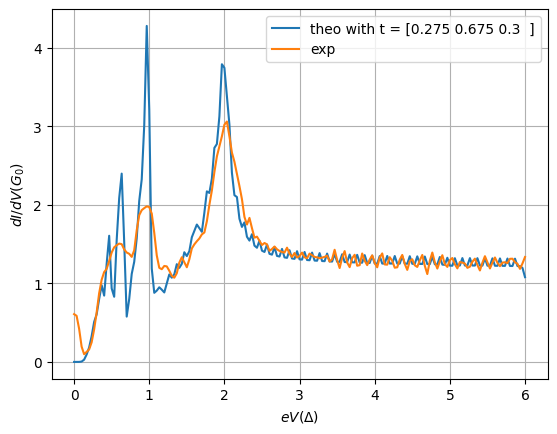

In [352]:
plt.close(7)
plt.figure(7)
plt.plot(V_norm, np.gradient(I_theo, V_norm), label=f'theo with t = {transmissions}')
plt.plot(V_norm, np.gradient(I_norm_down, V_norm), label='exp')
plt.grid()
plt.legend()
plt.xlabel(r'$eV (\Delta)$')
plt.ylabel(r'$dI/dV (G_0)$')

In [345]:
T_len = len(Transmission)
MSD = np.zeros((10000000, 6), dtype='int8')

z=0
for i in range(T_len):
    for j in range(T_len-i):
        j=i+j+1
        for k in range(T_len -j):
            k = k + j
            for l in range(T_len):
                for m in range(T_len):
                    for n in range(T_len):
                        I_theo = I_norm_theo[i,:] + I_norm_theo[j,:] + I_norm_theo[k,:]
                        I_theo = I_theo + I_norm_theo[l,:] + I_norm_theo[m,:] + I_norm_theo[n,:]
                        MSD[i,j,k,l,m,n] = np.mean((I_norm_down-I_theo)**2)
            
indices = np.array(np.unravel_index(np.argmin(MSD), (T_len, T_len, T_len, T_len, T_len, T_len)))
transmissions = Transmission[indices]
I_theo = I_norm_theo[0,:] + I_norm_theo[1,:] + I_norm_theo[2,:]
I_theo = I_theo + I_norm_theo[3,:] + I_norm_theo[4,:] + I_norm_theo[5,:]

IndexError: too many indices for array: array is 2-dimensional, but 6 were indexed

In [342]:

I_norm_down_mesh, _ = np.meshgrid(I_norm_down, Transmission)
I_norm_up_mesh, _ = np.meshgrid(I_norm_up, Transmission)

msd_down = np.mean((I_norm_down_mesh-I_norm_theo)**2, axis=1)
msd_up = np.mean((I_norm_up_mesh-I_norm_theo)**2, axis=1)


plt.plot(Transmission, msd_down, '.')
plt.plot(Transmission, msd_up, '.')

Transmission[np.argmin(msd_down)], Transmission[np.argmin(msd_up)]

7731052560

Text(0, 0.5, '$I (2e\\Delta/h$)')

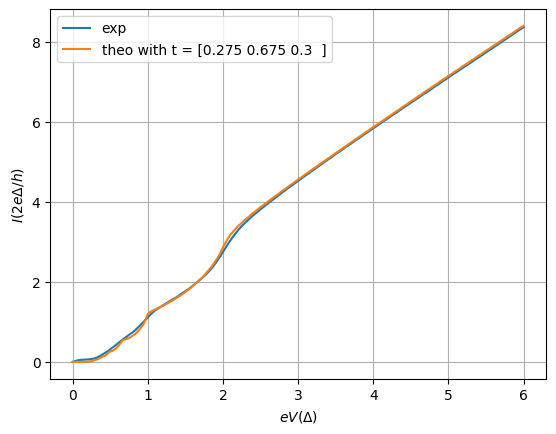